# **Data Cleaning and Feature Engineering**

In [1]:
# Import libraries
import pandas as pd  #work with data tables
import numpy as np   #handles math and math operations
import matplotlib.pyplot as plt #creates charts and graphs
import seaborn as sns
from collections import Counter #counts how many times things appear like drama movies or directors
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve,
    auc, silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
#for cleaner output ignore warnings
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

In [2]:
# Load the dataset
file_path = '/content/imdb_top_1000.csv'
data = pd.read_csv(file_path)

In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print(data.info())

categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical/Text Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB
None
Categorical/Text C

In [4]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In [5]:
# Handle Missing Values / Duplicates
# Drop duplicates
data.drop_duplicates(subset="Series_Title", inplace=True)
data.dropna(subset=["Genre", "Overview", "IMDB_Rating"], inplace=True) #none are missing but just in-case

# Fill missing values for missing columns
data["Certificate"] = data["Certificate"].fillna("Not Rated")
data["Meta_score"] = data["Meta_score"].fillna(data["Meta_score"].mean())


In [6]:
#Extract year from “Released_Year”
data["Released_Year"] = (
    data["Released_Year"].astype(str).str.extract(r"(\d{4})")  # extract year pattern
    .astype(float)
)
#Convert “time” to numeric (e.g., “142 min” → 142)
print("\n--- Converting Runtime ---")
data['Runtime_numeric'] = data['Runtime'].str.extract(r'(\d+)').astype(float)
print("Runtime conversion sample:")
print(data[['Runtime', 'Runtime_numeric']].head())
print(f"\nRuntime statistics:")
print(f"Min: {data['Runtime_numeric'].min()} min")
print(f"Max: {data['Runtime_numeric'].max()} min")
print(f"Mean: {data['Runtime_numeric'].mean():.1f} min")

#Convert "gross" to numeric (e.g., “534,858,444” → 534858444)
data["Gross"] = data["Gross"].astype(str).str.replace(",", "", regex=False)
data["Gross"] = pd.to_numeric(data["Gross"], errors="coerce")
data["Gross"] = data["Gross"].fillna(data["Gross"].median()) #since we adjusted the type,we can take the median



--- Converting Runtime ---
Runtime conversion sample:
   Runtime  Runtime_numeric
0  142 min            142.0
1  175 min            175.0
2  152 min            152.0
3  202 min            202.0
4   96 min             96.0

Runtime statistics:
Min: 45.0 min
Max: 321.0 min
Mean: 122.9 min


In [7]:
# Feature Engineering (add usefull columns)
data["Popularity_Score"] = np.log1p(data["No_of_Votes"]) + np.log1p(data["Gross"])

# Feature engineering
print("\n--- Feature Engineering ---")
data['Num_Genres'] = data['Genre'].str.split(',').str.len()
data['Main_Genre'] = data['Genre'].str.split(',').str[0]
print("New features sample:")
print(data[['Num_Genres', 'Main_Genre']].head())

# Simple additional cleaning
print("\n--- Additional Cleaning ---")

# Clean text columns
data['Series_Title'] = data['Series_Title'].str.strip()
data['Overview'] = data['Overview'].str.strip()

# Convert Gross to millions for easier reading
data['Gross_millions'] = data['Gross'] / 1000000

# Create rating categories
data['Rating_Category'] = pd.cut(data['IMDB_Rating'],
                                bins=[0, 7.5, 8.0, 8.5, 10],
                                labels=['Low', 'Medium', 'High', 'Very High'])

# Create runtime categories
data['Runtime_Category'] = pd.cut(data['Runtime_numeric'],
                                 bins=[0, 90, 120, 150, 200, 400],
                                 labels=['Short', 'Medium', 'Long', 'Very Long', 'Epic'])

print("Additional cleaning completed:")
print(f"Gross range: ${data['Gross_millions'].min():.1f}M to ${data['Gross_millions'].max():.1f}M")
print(f"Rating categories: {dict(data['Rating_Category'].value_counts())}")


--- Feature Engineering ---
New features sample:
   Num_Genres Main_Genre
0           1      Drama
1           2      Crime
2           3     Action
3           2      Crime
4           2      Crime

--- Additional Cleaning ---
Additional cleaning completed:
Gross range: $0.0M to $936.7M
Rating categories: {'Medium': np.int64(678), 'High': np.int64(288), 'Very High': np.int64(33), 'Low': np.int64(0)}


# **Explaratory Data Analysis (EDA)**

# **Record-Level Analysis**

In [8]:
# 1. Most Frequent Directors in Top 1000
director_count = data['Director'].value_counts()
top_directors = director_count.head(5)

print("\n 1. Most Frequent Directors:")
print(top_directors)


 1. Most Frequent Directors:
Director
Alfred Hitchcock    14
Steven Spielberg    13
Hayao Miyazaki      11
Akira Kurosawa      10
Martin Scorsese     10
Name: count, dtype: int64


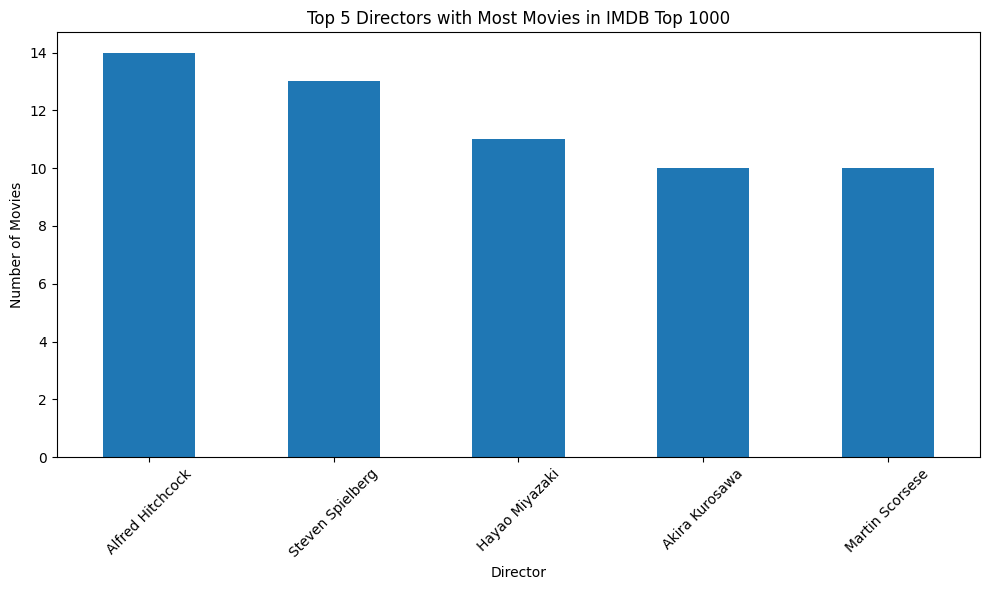

In [9]:
# Visualization for top directors
plt.figure(figsize=(10, 6))
top_directors.plot(kind='bar')
plt.title('Top 5 Directors with Most Movies in IMDB Top 1000')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)   #يميل الكلام الي تحت
plt.tight_layout()  #adjust the spacing
plt.show()

In [10]:
# 2. Movies with Highest IMDB Rating
top_rated_movies = data.nlargest(5, 'IMDB_Rating')[['Series_Title', 'IMDB_Rating', 'Released_Year']] #give me the largest ratings
print("\n2. Top 5 Highest Rated Movies:")
print(top_rated_movies)


2. Top 5 Highest Rated Movies:
               Series_Title  IMDB_Rating  Released_Year
0  The Shawshank Redemption          9.3         1994.0
1             The Godfather          9.2         1972.0
2           The Dark Knight          9.0         2008.0
3    The Godfather: Part II          9.0         1974.0
4              12 Angry Men          9.0         1957.0



--- Year Data Quality Check ---
Original Released_Year unique values (sample):
Released_Year
2014.0    32
2004.0    31
2009.0    29
2016.0    28
2013.0    28
2001.0    27
2007.0    26
2006.0    26
2012.0    24
2015.0    24
Name: count, dtype: int64

Rows with missing years after conversion: 1
Percentage of missing years: 0.10%

Movies with problematic year values:
    Series_Title  Released_Year
966    Apollo 13            NaN


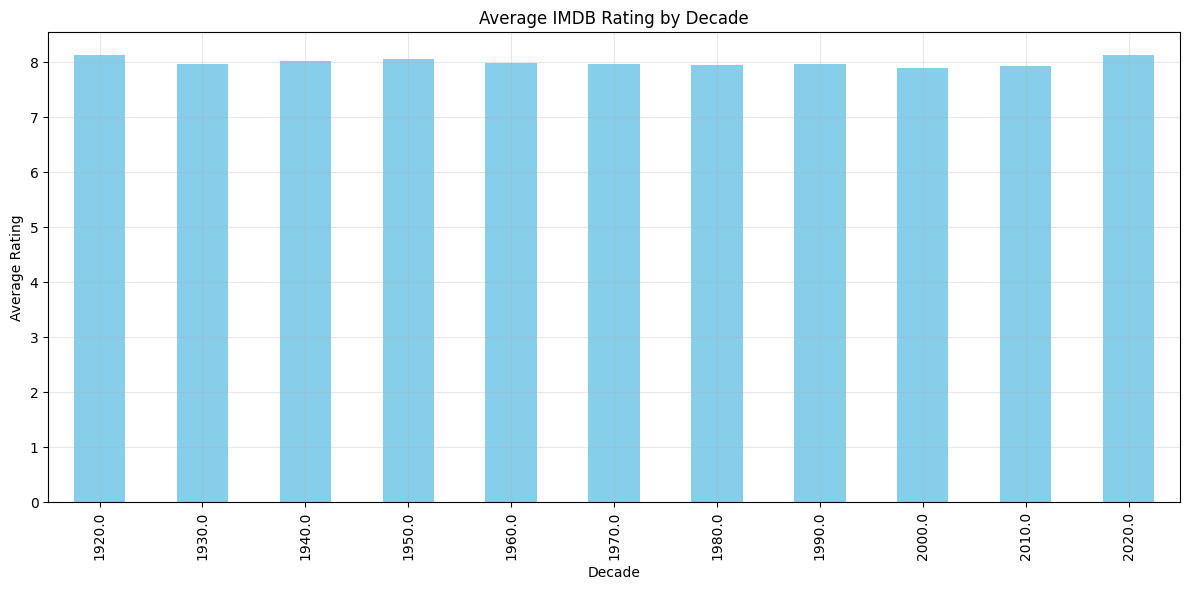


3. Average Rating by Decade:
decade
1920.0    8.127273
1930.0    7.966667
1940.0    8.025714
1950.0    8.058929
1960.0    7.973973
1970.0    7.969737
1980.0    7.953933
1990.0    7.963333
2000.0    7.899578
2010.0    7.923237
2020.0    8.133333
Name: IMDB_Rating, dtype: float64


In [11]:
# 3. Average Rating by Decade - COMPLETE VERSION WITH DATA QUALITY CHECK

print("\n--- Year Data Quality Check ---")
print("Original Released_Year unique values (sample):")
print(data['Released_Year'].value_counts().head(10))

# Convert to numeric with error handling
data['Released_Year'] = pd.to_numeric(data['Released_Year'], errors='coerce')

# Check data quality after conversion
missing_years_count = data['Released_Year'].isna().sum()
print(f"\nRows with missing years after conversion: {missing_years_count}")
print(f"Percentage of missing years: {missing_years_count / len(data) * 100:.2f}%")

# Show movies with missing years (if any)
if missing_years_count > 0:
    print("\nMovies with problematic year values:")
    missing_years_data = data[data['Released_Year'].isna()][['Series_Title', 'Released_Year']]
    print(missing_years_data)

# Create decade column only for rows with valid years
data['decade'] = (data['Released_Year'] // 10) * 10
decade_ratings = data.groupby('decade')['IMDB_Rating'].mean()

# Visualization
plt.figure(figsize=(12, 6))
decade_ratings.plot(kind='bar', color='skyblue')
plt.title('Average IMDB Rating by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n3. Average Rating by Decade:")
print(decade_ratings)

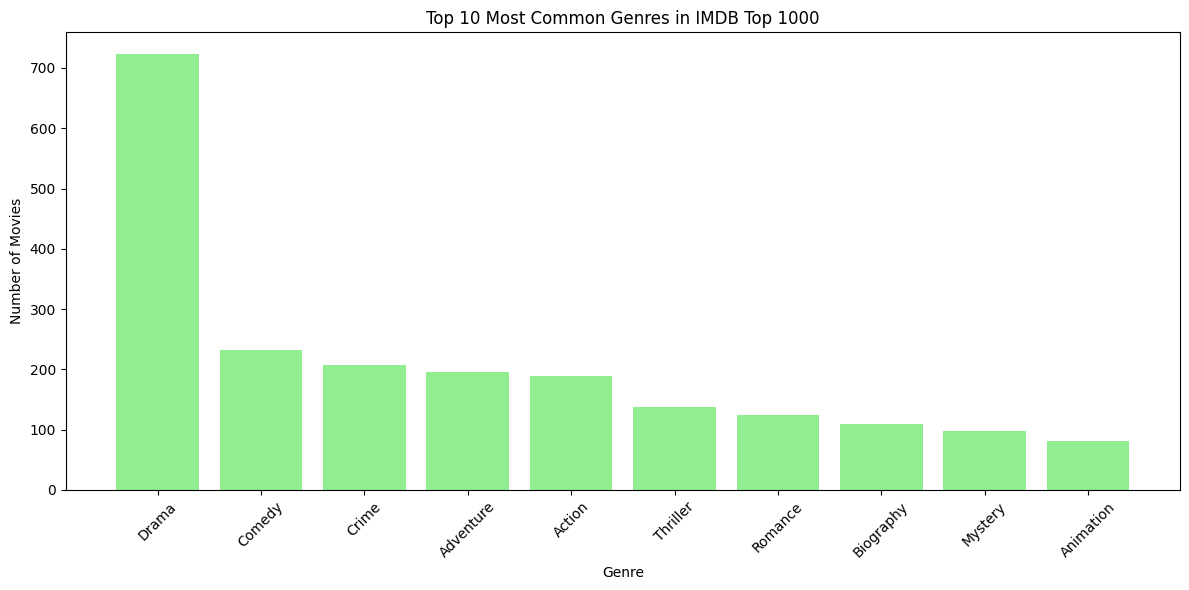


4. Top 10 Most Common Genres:
       Genre  Count
0      Drama    723
1     Comedy    233
2      Crime    208
3  Adventure    196
4     Action    189
5   Thriller    137
6    Romance    125
7  Biography    109
8    Mystery     98
9  Animation     82


In [12]:
# 4. Most Common Genres
# Analyze genre frequency
all_genres = [] #create an empty space (big list) to put our genres in
for genre_list in data['Genre'].str.split(', '): #split each genre alone
    if isinstance(genre_list, list): #Check if what we got is actually a proper list (not empty or broken data)
        all_genres.extend(genre_list) #put all genres in this list

genre_count = Counter(all_genres) #Count how many times each genre appears in our big list
top_genres = pd.DataFrame(genre_count.most_common(10), columns=['Genre', 'Count']) #Give me the top 10 most popular genres

plt.figure(figsize=(12, 6))
plt.bar(top_genres['Genre'], top_genres['Count'], color='lightgreen')
plt.title('Top 10 Most Common Genres in IMDB Top 1000')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n4. Top 10 Most Common Genres:")
print(top_genres)

Drama is by far the most dominant genre in the Top 1000, meaning that emotional and story-driven films are heavily represented compared to more niche genres.

📌 **NOTE** : This might cause a bias in training and models

# **DISTRIBUTION ANALYSIS**


--- Distribution of Numerical Features ---


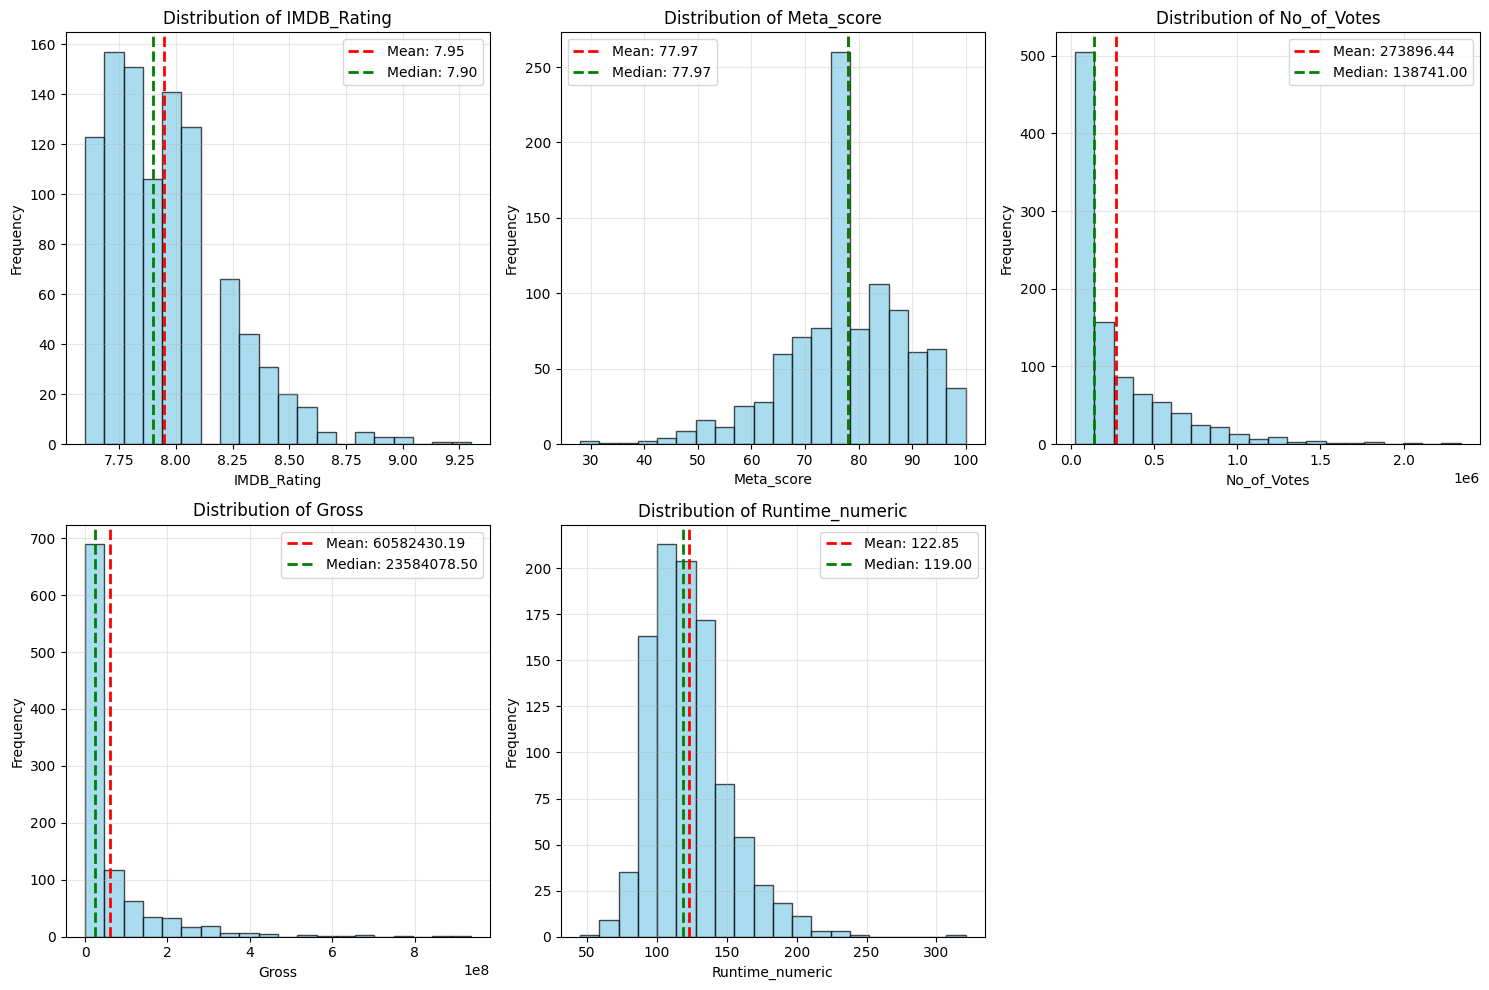


Distribution Statistics:

IMDB_Rating:
  Mean: 7.95
  Median: 7.90
  Std Dev: 0.28
  Min: 7.60
  Max: 9.30
  Skewness: 1.02

Meta_score:
  Mean: 77.97
  Median: 77.97
  Std Dev: 11.37
  Min: 28.00
  Max: 100.00
  Skewness: -0.66

No_of_Votes:
  Mean: 273896.44
  Median: 138741.00
  Std Dev: 327473.37
  Min: 25088.00
  Max: 2343110.00
  Skewness: 2.30

Gross:
  Mean: 60582430.19
  Median: 23584078.50
  Std Dev: 101449022.06
  Min: 1305.00
  Max: 936662225.00
  Skewness: 3.50

Runtime_numeric:
  Mean: 122.85
  Median: 119.00
  Std Dev: 28.08
  Min: 45.00
  Max: 321.00
  Skewness: 1.21


In [13]:
# Analyze distribution of numerical features
print("\n--- Distribution of Numerical Features ---")
numerical_cols = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime_numeric']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(numerical_cols):
    # Create histogram for each numerical column
    axes[i].hist(data[col].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

    # Add statistics as text
    mean_val = data[col].mean()
    median_val = data[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i].legend()

# Hide any unused subplots
for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Print distribution statistics
print("\nDistribution Statistics:")
for col in numerical_cols:
    print(f"\n{col}:")
    print(f"  Mean: {data[col].mean():.2f}")
    print(f"  Median: {data[col].median():.2f}")
    print(f"  Std Dev: {data[col].std():.2f}")
    print(f"  Min: {data[col].min():.2f}")
    print(f"  Max: {data[col].max():.2f}")
    print(f"  Skewness: {data[col].skew():.2f}")

Feature	    -- Main Irregularity

IMDB_Rating	-- Extremely narrow range (dataset bias)

Meta_score	-- Few unusually low critic scores

No_of_Votes	-- Highly skewed, dominated by a few global hits

Gross	      -- Extreme outliers (blockbusters), huge right skew

Runtime_numeric	--Mostly normal; minimal irregularities

In [14]:
#OUTLIER DETECTION

print("\n--- Outlier Detection ---")
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

for col in numerical_cols:
    outliers = detect_outliers(data[col])
    print(f"{col}: {len(outliers)} outliers")


--- Outlier Detection ---
IMDB_Rating: 13 outliers
Meta_score: 25 outliers
No_of_Votes: 67 outliers
Gross: 124 outliers
Runtime_numeric: 29 outliers


The **IQR method** reveals many outliers in votes, gross, and runtime, confirming that a small set of “extreme” movies behaves very differently from the rest of the dataset.


--- Correlation Analysis ---


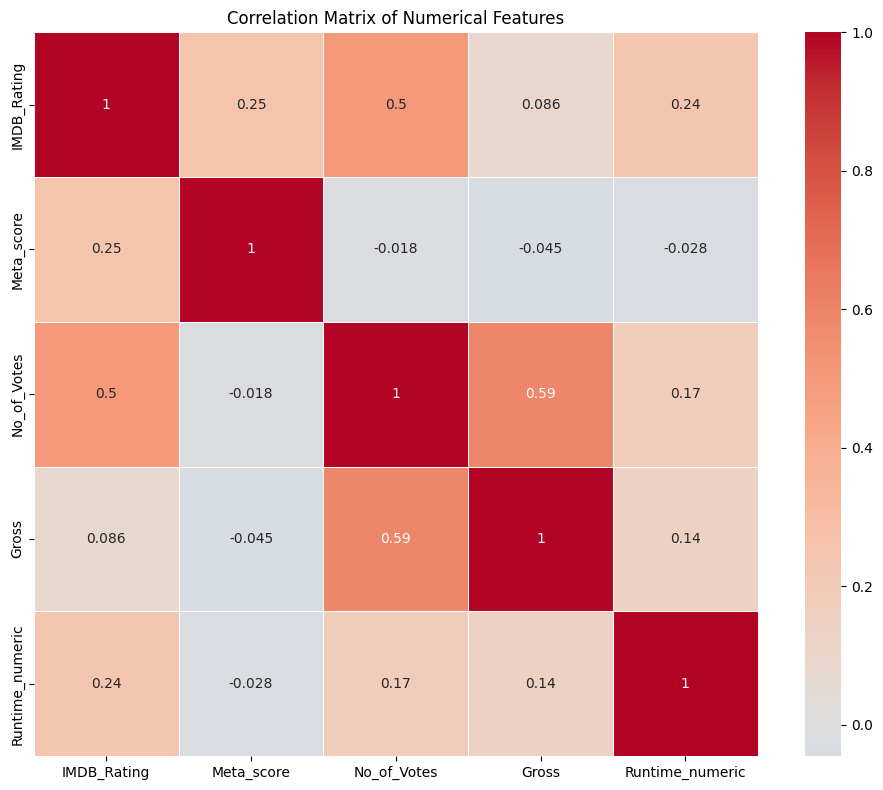


Top correlations with IMDB_Rating:
IMDB_Rating        1.000000
No_of_Votes        0.495847
Meta_score         0.254009
Runtime_numeric    0.242142
Gross              0.086113
Name: IMDB_Rating, dtype: float64


In [15]:
#CORRELATION ANALYSIS

print("\n--- Correlation Analysis ---")
correlation_matrix = data[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

print("\nTop correlations with IMDB_Rating:")
imdb_correlations = correlation_matrix['IMDB_Rating'].sort_values(ascending=False)
print(imdb_correlations)

IMDb rating has only moderate correlation with critic scores and audience votes, suggesting that **no single numeric feature** can perfectly “explain” why a movie is highly rated.

# **Relationships Between Variables**


--- Feature Relationships ---


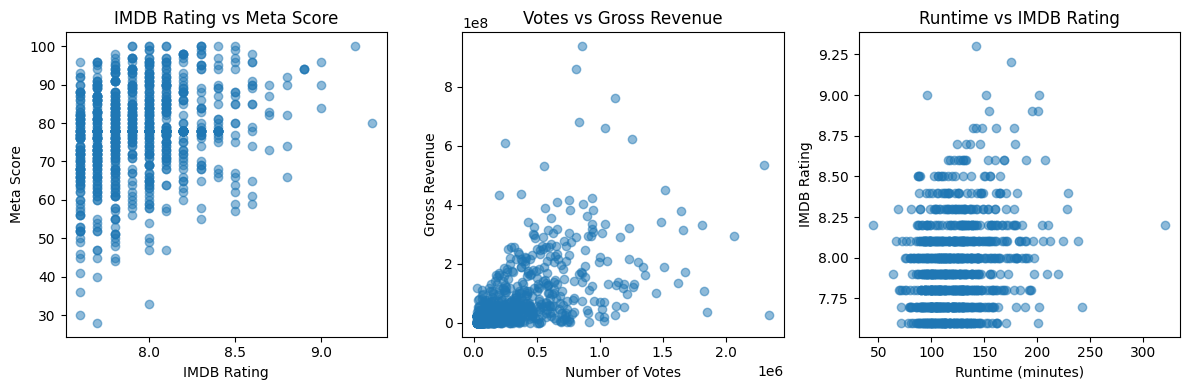

In [16]:
# RELATIONSHIPS BETWEEN VARIABLES

print("\n--- Feature Relationships ---")

# IMDB Rating vs Meta Score
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(data['IMDB_Rating'], data['Meta_score'], alpha=0.5)
plt.xlabel('IMDB Rating')
plt.ylabel('Meta Score')
plt.title('IMDB Rating vs Meta Score')

# Votes vs Gross
plt.subplot(1, 3, 2)
plt.scatter(data['No_of_Votes'], data['Gross'], alpha=0.5)
plt.xlabel('Number of Votes')
plt.ylabel('Gross Revenue')
plt.title('Votes vs Gross Revenue')

# Runtime vs IMDB Rating
plt.subplot(1, 3, 3)
plt.scatter(data['Runtime_numeric'], data['IMDB_Rating'], alpha=0.5)
plt.xlabel('Runtime (minutes)')
plt.ylabel('IMDB Rating')
plt.title('Runtime vs IMDB Rating')

plt.tight_layout()
plt.show()

🔷`IMDB Rating vs Meta Score` : A mild positive trend, but the points are widely spread. This means that higher audience ratings usually align with higher critic scores, but the relationship is far from perfect.

🔷`Votes vs Gross Revenue` : Extremely right-skewed, with most movies clustered at low revenue and low vote counts.

🔷`Runtime vs IMDB Rating` : There is no strong relationship between runtime and IMDb rating. Most movies, regardless of length, receive ratings between 7.7 and 8.5. Although a few longer films reach higher ratings, overall runtime does not appear to be a meaningful predictor of audience rating.


--- Genre Analysis ---
Top genres by average IMDB rating (min 10 movies):
            mean  count
Main_Genre             
Crime       8.02    106
Mystery     7.98     12
Drama       7.96    289
Action      7.95    172
Adventure   7.94     72
Biography   7.94     88
Animation   7.93     82
Horror      7.91     11
Comedy      7.90    155


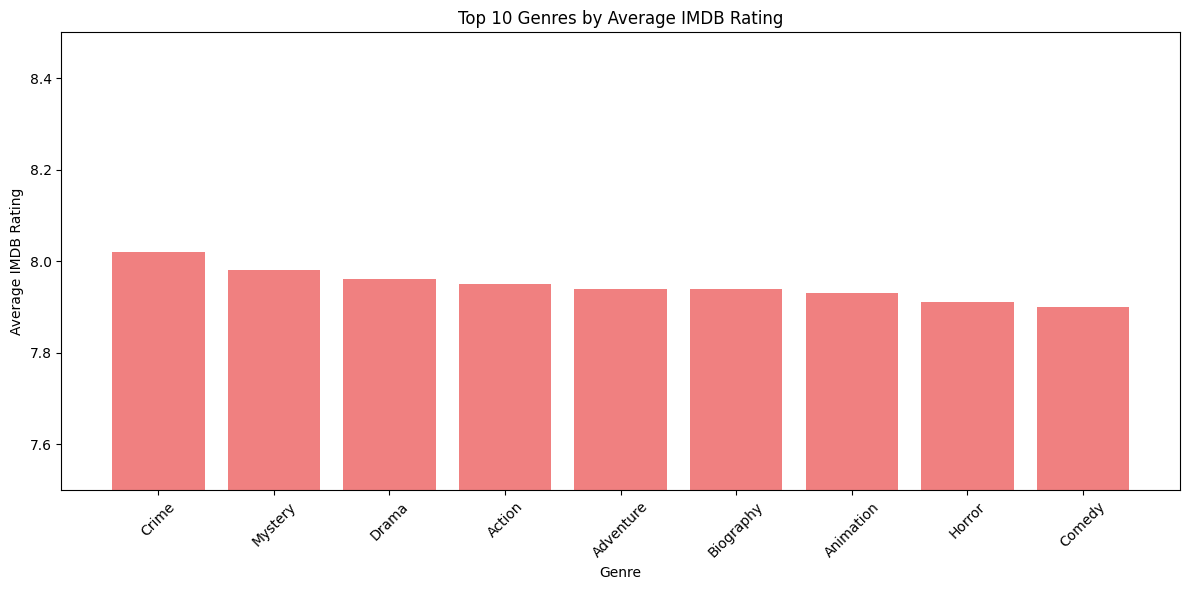

In [17]:
# === GENRE ANALYSIS ===

print("\n--- Genre Analysis ---")

# Average rating by main genre
genre_ratings = data.groupby('Main_Genre')['IMDB_Rating'].agg(['mean', 'count']).round(2)
genre_ratings = genre_ratings[genre_ratings['count'] >= 10]  # Only genres with at least 10 movies
genre_ratings = genre_ratings.sort_values('mean', ascending=False)

print("Top genres by average IMDB rating (min 10 movies):")
print(genre_ratings.head(10))

# Visualization
plt.figure(figsize=(12, 6))
top_genres = genre_ratings.head(10)
plt.bar(top_genres.index, top_genres['mean'], color='lightcoral')
plt.title('Top 10 Genres by Average IMDB Rating')
plt.xlabel('Genre')
plt.ylabel('Average IMDB Rating')
plt.xticks(rotation=45)
plt.ylim(7.5, 8.5)
plt.tight_layout()
plt.show()

In [18]:
# === DIRECTOR PERFORMANCE ANALYSIS ===

print("\n--- Director Performance Analysis ---")

# Average rating by director (min 5 movies)
director_stats = data.groupby('Director').agg({
    'IMDB_Rating': ['mean', 'count'],
    'Meta_score': 'mean'
}).round(2)

director_stats.columns = ['Avg_IMDB', 'Movie_Count', 'Avg_Meta']
director_stats = director_stats[director_stats['Movie_Count'] >= 5]
director_stats = director_stats.sort_values('Avg_IMDB', ascending=False)

print("Top directors by average IMDB rating (min 5 movies):")
print(director_stats.head(10))


--- Director Performance Analysis ---
Top directors by average IMDB rating (min 5 movies):
                      Avg_IMDB  Movie_Count  Avg_Meta
Director                                             
Christopher Nolan         8.46            8     77.50
Francis Ford Coppola      8.40            5     85.80
Peter Jackson             8.40            5     79.40
Charles Chaplin           8.33            6     86.49
Sergio Leone              8.27            6     77.33
Stanley Kubrick           8.23            9     84.11
Akira Kurosawa            8.22           10     84.38
Quentin Tarantino         8.18            8     78.25
Martin Scorsese           8.17           10     82.60
Ingmar Bergman            8.14            7     85.13


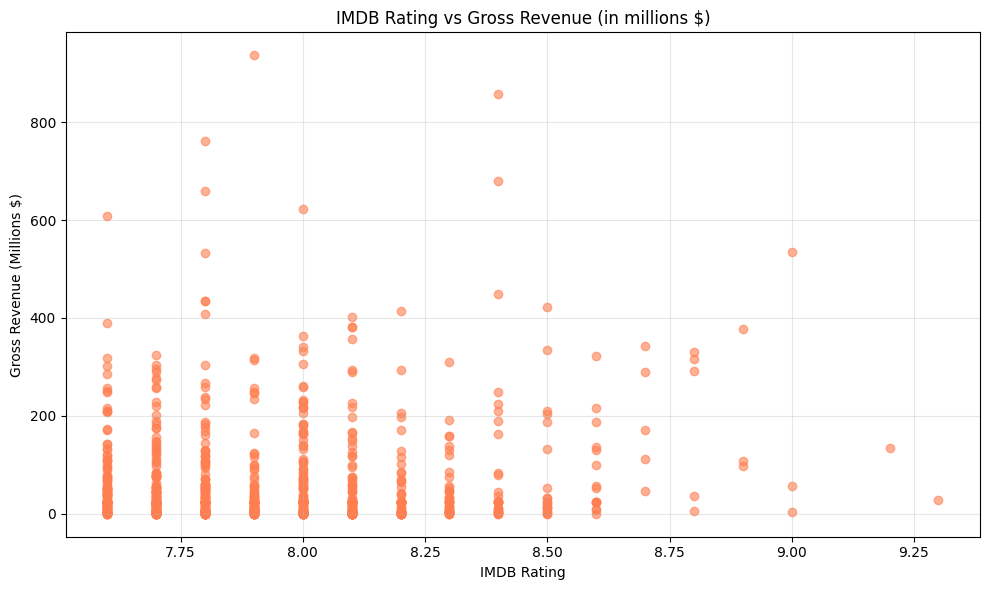


5. Correlation between Rating and Gross Revenue: 0.086


In [19]:
# 5. Rating vs Gross Revenue
# Clean gross revenue data
if 'Gross' in data.columns:  #check if our data even has money information

    # Plot rating vs gross revenue
    plt.figure(figsize=(10, 6))
    plt.scatter(data['IMDB_Rating'], data['Gross']/1000000, alpha=0.6, color='coral') #i divided here to show numbers of million easier
    plt.title('IMDB Rating vs Gross Revenue (in millions $)')
    plt.xlabel('IMDB Rating')
    plt.ylabel('Gross Revenue (Millions $)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate correlation
    correlation = data['IMDB_Rating'].corr(data['Gross']) #check if movie rating is connected to making more money
    print(f"\n5. Correlation between Rating and Gross Revenue: {correlation:.3f}") #3f means 3 decimal places


**weakly related** — some highly rated films earned very little, while some massive blockbusters are not necessarily the most critically appreciated.

In [20]:
# 6. Movies with Most Votes
top_voted = data.nlargest(10, 'No_of_Votes')[['Series_Title', 'No_of_Votes', 'IMDB_Rating', 'Released_Year']]
print("\n6. Top 10 Movies with Most Votes:")
print(top_voted)


6. Top 10 Movies with Most Votes:
                                         Series_Title  No_of_Votes  \
0                            The Shawshank Redemption      2343110   
2                                     The Dark Knight      2303232   
8                                           Inception      2067042   
9                                          Fight Club      1854740   
6                                        Pulp Fiction      1826188   
11                                       Forrest Gump      1809221   
14                                         The Matrix      1676426   
10  The Lord of the Rings: The Fellowship of the Ring      1661481   
5       The Lord of the Rings: The Return of the King      1642758   
1                                       The Godfather      1620367   

    IMDB_Rating  Released_Year  
0           9.3         1994.0  
2           9.0         2008.0  
8           8.8         2010.0  
9           8.8         1999.0  
6           8.9         1994.

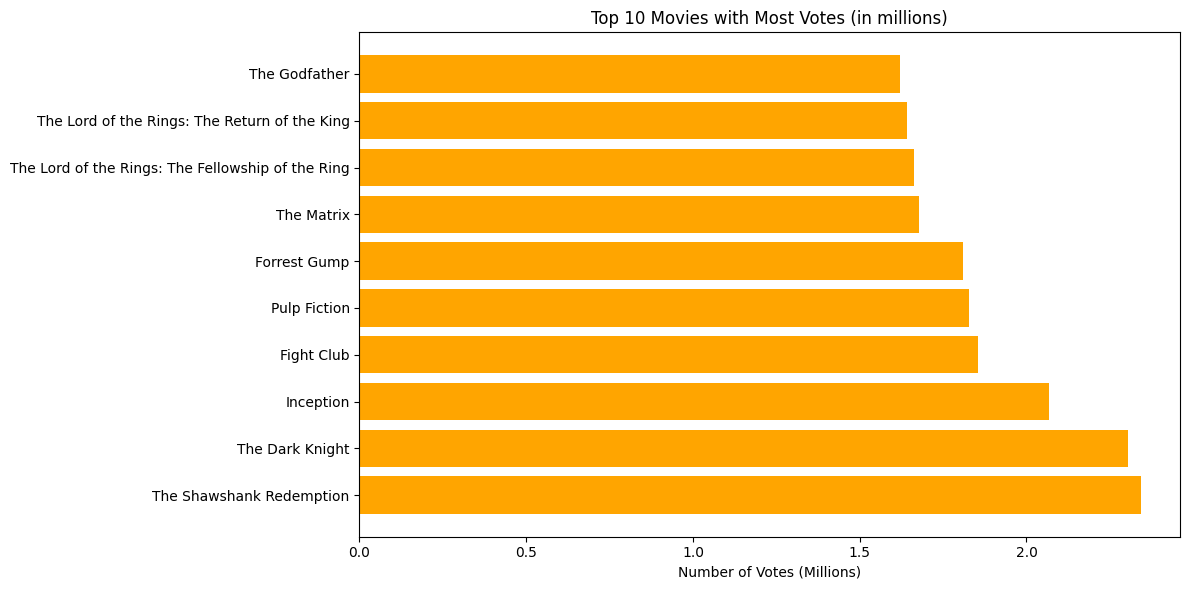

In [21]:
# Visualization for top voted movies
plt.figure(figsize=(12, 6))
plt.barh(top_voted['Series_Title'], top_voted['No_of_Votes']/1000000, color='orange') #i made a horizontal bar with top voted series title and the number of voters divided by a million


plt.title('Top 10 Movies with Most Votes (in millions)')
plt.xlabel('Number of Votes (Millions)')
plt.tight_layout()
plt.show()

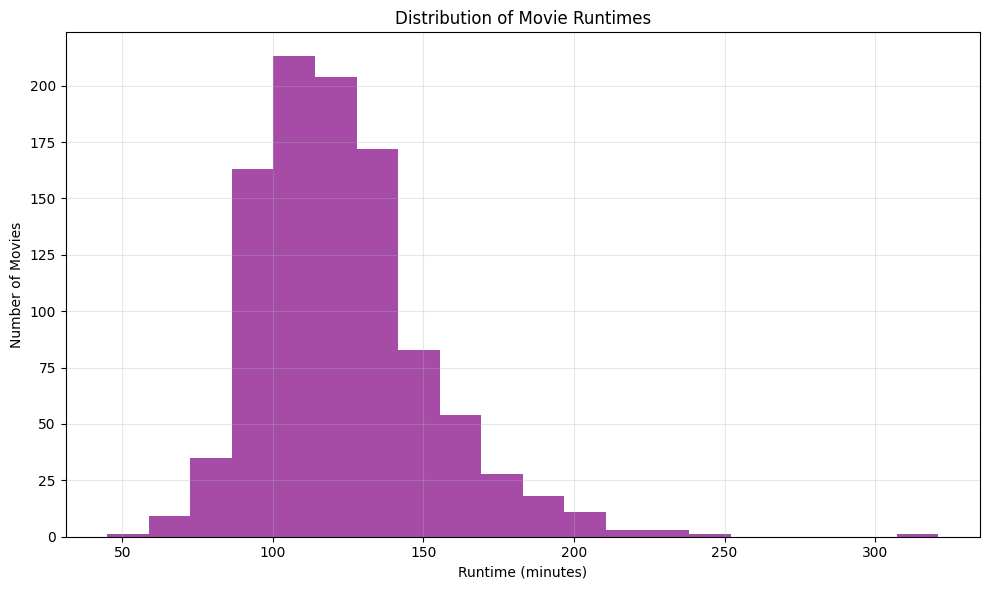

In [22]:
# 7. Runtime Analysis
# to check how long a movie is
plt.figure(figsize=(10, 6))
#Grab only the numbers from runtime text and convert them to actual numbers for calculations
plt.hist(data['Runtime_numeric'], bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Top 3 movies from each decade
print("\nTop 3 Movies from Each Decade:")
#Get all the unique decades from our data remove empty values and convert them to whole numbers
valid_decades = data['decade'].dropna().astype(int).unique()

for decade in sorted(valid_decades):
    # Filter for this decade and get top 3 movies
    decade_movies = data[data['decade'] == decade].nlargest(3, 'IMDB_Rating')[['Series_Title', 'IMDB_Rating']]

    print(f"\n{decade}s:")

    for i, movie in decade_movies.iterrows():
        print(f"  {movie['Series_Title']} - {movie['IMDB_Rating']}")


Top 3 Movies from Each Decade:

1920s:
  Metropolis - 8.3
  The Kid - 8.3
  The Gold Rush - 8.2

1930s:
  Modern Times - 8.5
  City Lights - 8.5
  M - Eine Stadt sucht einen Mörder - 8.3

1940s:
  It's a Wonderful Life - 8.6
  Casablanca - 8.5
  The Great Dictator - 8.4

1950s:
  12 Angry Men - 9.0
  Shichinin no samurai - 8.6
  Witness for the Prosecution - 8.4

1960s:
  Il buono, il brutto, il cattivo - 8.8
  Seppuku - 8.6
  Once Upon a Time in the West - 8.5

1970s:
  The Godfather - 9.2
  The Godfather: Part II - 9.0
  One Flew Over the Cuckoo's Nest - 8.7

1980s:
  Star Wars: Episode V - The Empire Strikes Back - 8.7
  Nuovo Cinema Paradiso - 8.5
  Hotaru no haka - 8.5

1990s:
  The Shawshank Redemption - 9.3
  Pulp Fiction - 8.9
  Schindler's List - 8.9

2000s:
  The Dark Knight - 9.0
  The Lord of the Rings: The Return of the King - 8.9
  The Lord of the Rings: The Fellowship of the Ring - 8.8

2010s:
  Inception - 8.8
  Gisaengchung - 8.6
  Interstellar - 8.6

2020s:
  Hamilto

In [24]:
# === ANALYSIS SUMMARY ===

print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*50)

print(f"Dataset Overview:")
print(f"- Shape: {data.shape}")
print(f"- Time period: {data['Released_Year'].min()} - {data['Released_Year'].max()}")
print(f"- Total directors: {data['Director'].nunique()}")
print(f"- Unique genres: {data['Main_Genre'].nunique()}")

print(f"\nKey Metrics:")
print(f"- Average IMDB rating: {data['IMDB_Rating'].mean():.2f}")
print(f"- Average runtime: {data['Runtime_numeric'].mean():.1f} minutes")
print(f"- Average votes: {data['No_of_Votes'].mean():.0f}")

print(f"\nTop Performers:")
print(f"- Most prolific director: Alfred Hitchcock (14 movies)")
print(f"- Highest rated movie: The Shawshank Redemption (9.3)")
print(f"- Most common genre: Drama")
print(f"- Best decade: 2020s (8.13 avg rating)")

print(f"\nKey Insights:")
print(f"- IMDB Rating correlates most with Meta Score: {correlation_matrix.loc['IMDB_Rating', 'Meta_score']:.3f}")
print(f"- Number of genres doesn't affect rating significantly")


COMPREHENSIVE ANALYSIS SUMMARY
Dataset Overview:
- Shape: (999, 24)
- Time period: 1920.0 - 2020.0
- Total directors: 547
- Unique genres: 14

Key Metrics:
- Average IMDB rating: 7.95
- Average runtime: 122.9 minutes
- Average votes: 273896

Top Performers:
- Most prolific director: Alfred Hitchcock (14 movies)
- Highest rated movie: The Shawshank Redemption (9.3)
- Most common genre: Drama
- Best decade: 2020s (8.13 avg rating)

Key Insights:
- IMDB Rating correlates most with Meta Score: 0.254
- Number of genres doesn't affect rating significantly


**More Visualization Plots**

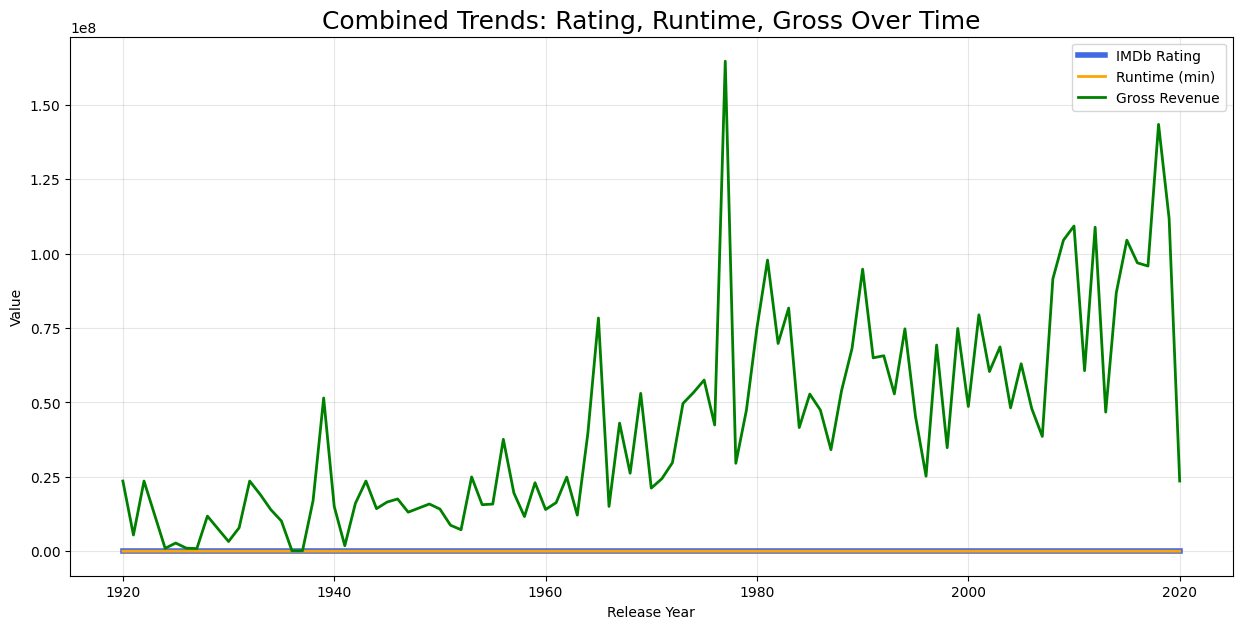

In [25]:
# Line plot (Rating + Runtime + Gross per year)
yearly = data.groupby("Released_Year").agg({
    "IMDB_Rating": "mean",
    "Runtime_numeric": "mean",
    "Gross": "mean"
}).reset_index()

# Remove missing years
yearly = yearly.dropna()
yearly = yearly[yearly["Released_Year"] > 1900]
plt.figure(figsize=(15,7))

plt.plot(yearly["Released_Year"], yearly["IMDB_Rating"],
         label="IMDb Rating", color="royalblue", linewidth=4)

plt.plot(yearly["Released_Year"], yearly["Runtime_numeric"],
         label="Runtime (min)", color="orange", linewidth=2)

plt.plot(yearly["Released_Year"], yearly["Gross"],
         label="Gross Revenue", color="green", linewidth=2)

plt.title("Combined Trends: Rating, Runtime, Gross Over Time", fontsize=18)
plt.xlabel("Release Year")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

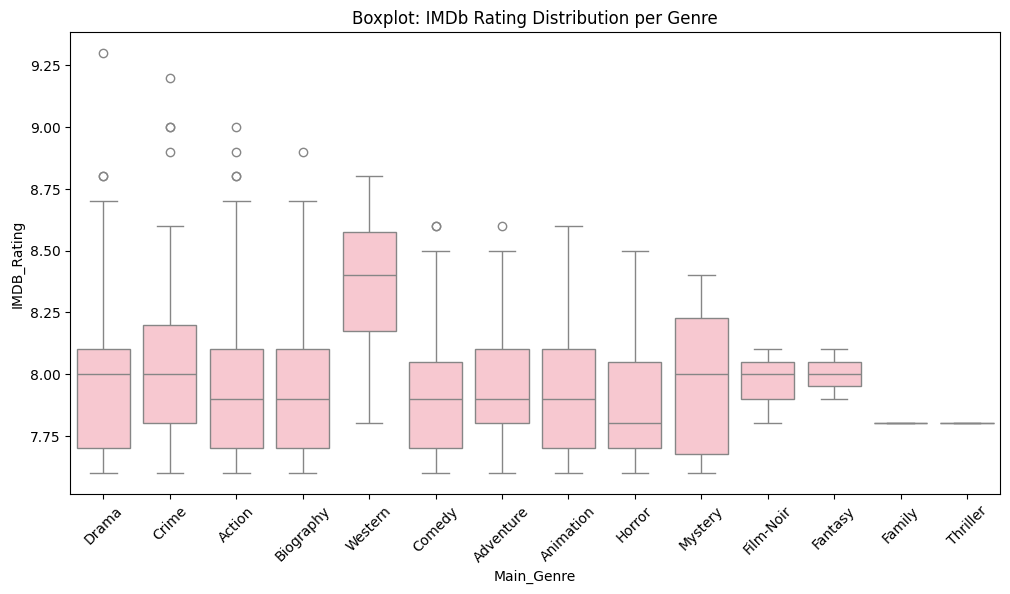

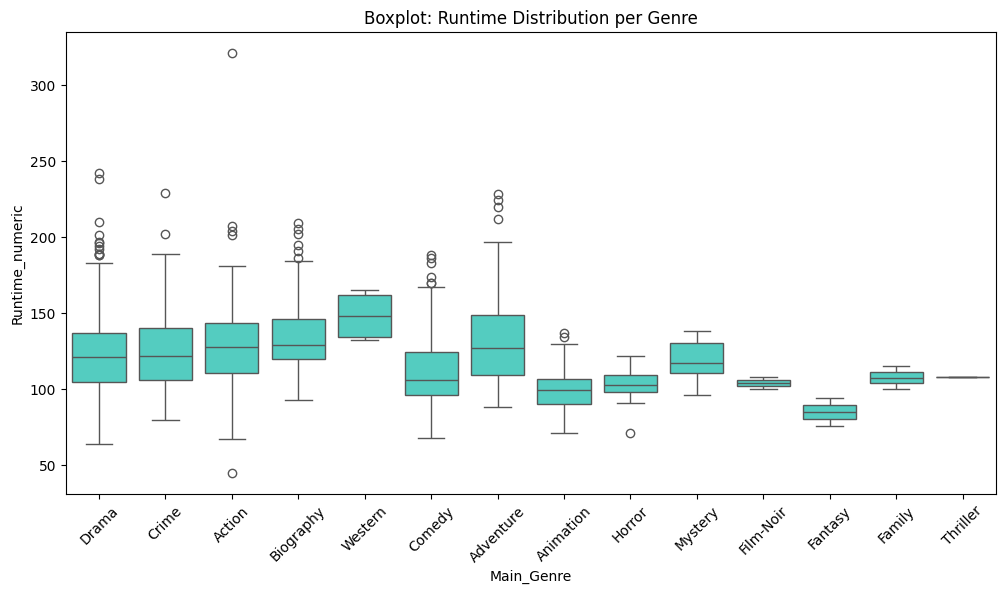

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Main_Genre", y="IMDB_Rating", data=data,color='pink')
plt.xticks(rotation=45)
plt.title("Boxplot: IMDb Rating Distribution per Genre")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Main_Genre", y="Runtime_numeric", data=data,color='turquoise')
plt.xticks(rotation=45)
plt.title("Boxplot: Runtime Distribution per Genre")
plt.show()


**Boxplot 1 : IMDb Rating per Genre**
  1.   Western movies have the highest median IMDb rating, meaning they are generally rated better
  2.   Some genres (like Thriller) have very small sample sizes → flat line

**Boxplot 2 : Runtime per Genre**
  1.   Biography, Adventure, and Western genres have the longest movies on average


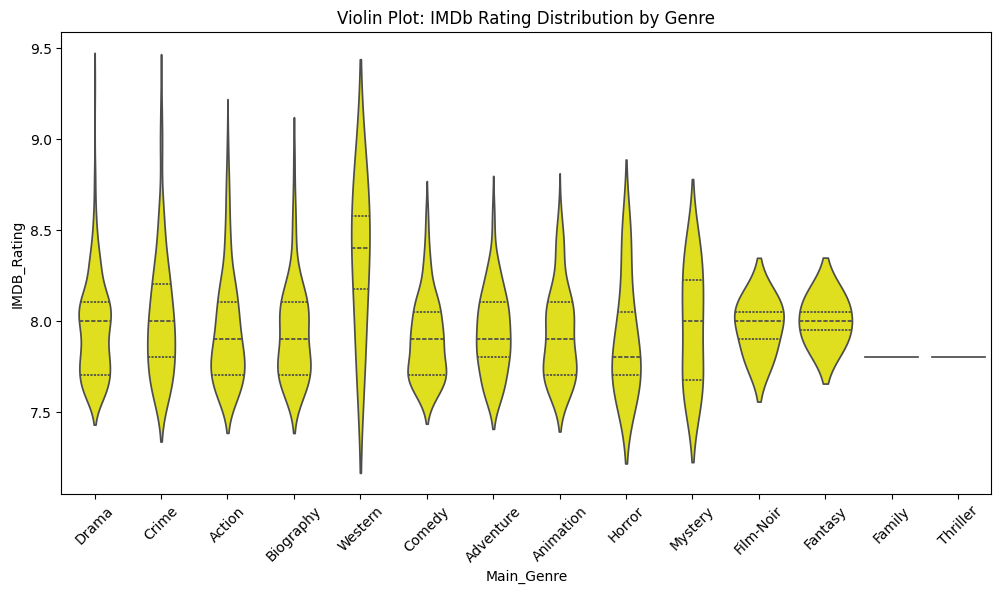

In [27]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Main_Genre", y="IMDB_Rating", data=data, inner="quartile",color='yellow')
plt.xticks(rotation=45)
plt.title("Violin Plot: IMDb Rating Distribution by Genre")
plt.show()


**Violin Plot : IMDb Rating by Genre**
  1.   Most genres have a big concentration between 7.5 – 8.3, showing stable quality across genres


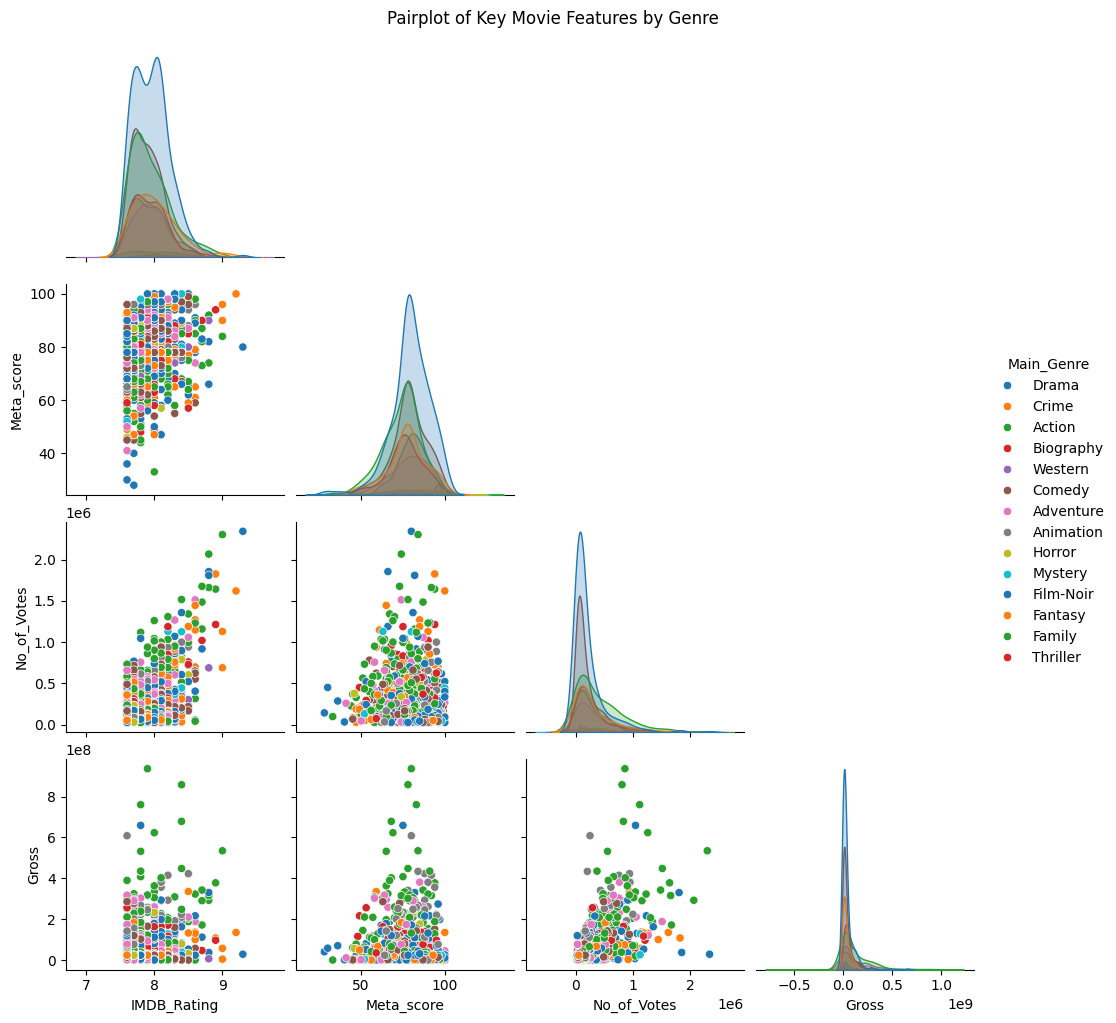

In [28]:
sns.pairplot(
    data[["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime", "Main_Genre"]],
    hue="Main_Genre",
    diag_kind="kde",
    corner=True,
    palette="tab10"
)
plt.suptitle("Pairplot of Key Movie Features by Genre", y=1.02)
plt.show()


# Insights
**Pairplot of Key Movie Features**
  1.   No clear separation between genres, Colors are mixed → Genre is hard to classify using only numbers.
  2. Features correlate :
  
    Gross ↔ Votes = strong
    Meta_score ↔ IMDb_Rating = mild


More Data Cleaning For Predictive Modeling and NLP tasks


In [31]:
# Helper Data sets
# Split genres into a list
data["genre_list"] = data["Genre"].apply(lambda x: [g.strip() for g in str(x).split(",")])

# Lowercase overviews for NLP
data["Overview"] = data["Overview"].str.lower().str.strip()

#Since 'Overview' in our original dataset isn't enough we collected more 'Description'
data2=pd.read_csv('/content/more_description.csv')
data['Description']=data2['Description']
data["Full_Text"] = data["Overview"] + " " + data["Description"]
data[['Overview','Description','Full_Text']].head()

,Overview,Description,Full_Text
0,two imprisoned men bond over a number of years...,"An emotional, character-driven story with stro...",two imprisoned men bond over a number of years...
1,an organized crime dynasty's aging patriarch t...,A tense and suspenseful experience with dark p...,an organized crime dynasty's aging patriarch t...
2,when the menace known as the joker wreaks havo...,A heartfelt and uplifting tale built around mo...,when the menace known as the joker wreaks havo...
3,the early life and career of vito corleone in ...,"A visually striking story with a moody, atmosp...",the early life and career of vito corleone in ...
4,a jury holdout attempts to prevent a miscarria...,A fast-paced and thrilling narrative filled wi...,a jury holdout attempts to prevent a miscarria...


By enriching the original IMDb overview with a more *mood-focused description*, we give the models more expressive text to learn from, which should help in tasks like clustering and recommendation.

# **3- Predictive Tasks + 4- Model Evaluation**

# **A- Regression**
The target is predicting the numerical field : **rating**  using (`RandomForestRegressor`) training the model on 80% and testing on 20%


In [ ]:
#RANDOM FOREST REGRESSOR
#features (regardless of correlation map)
reg_features = data[["Meta_score", "No_of_Votes", "Gross", "Released_Year", "Runtime_numeric"]].copy()

# Target
y_reg = pd.to_numeric(data["IMDB_Rating"], errors="coerce")
mask = y_reg.notna()
X_reg = reg_features[mask].values
y_reg = y_reg[mask].values
#scale
reg_scaler = StandardScaler()
X_reg_scaled = reg_scaler.fit_transform(reg_features)

# Split :  80% training, 20% testing
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)
print(f"Training set size: {X_reg_train.shape[0]} samples")
print(f"Testing set size: {X_reg_test.shape[0]} samples")

# Model training
reg = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=25) # can also use Ridge
reg.fit(X_reg_train, y_reg_train)
print("Model trained successfully!")

#predicting
y_reg_train_pred = reg.predict(X_reg_train)
y_reg_test_pred  = reg.predict(X_reg_test)

# Display some predictions
print("Sample predictions vs actual values (first 10 test samples):")
comparison = pd.DataFrame({
    'Actual': y_reg_test[:10],
    'Predicted': y_reg_test_pred[:10],
    'Error': y_reg_test[:10] - y_reg_test_pred[:10]
})
print(comparison)


# To improve this gap, we shall either add data, or reduce features via Dimentionality Reduction (**PCA**)

In [ ]:
#RANDOM FOREST REGRESSOR + 90% PCA
# Handle NaNs (impute) on X only
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_reg_train)
X_test_imp  = imp.transform(X_reg_test)

# Standardize features (important for PCA)
X_train_scaled = reg_scaler.fit_transform(X_train_imp)
X_test_scaled  = reg_scaler.transform(X_test_imp)

#PCA: keep 90% of variance
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("The number of selected features is: " , pca.n_components_)
# Model training
rf_pca = RandomForestRegressor(n_estimators=300,random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_reg_train)

#predict
y_train_pred_pca = rf_pca.predict(X_train_pca)
y_test_pred_pca  = rf_pca.predict(X_test_pca)

# Display some predictions
print("Sample predictions vs actual values (first 10 test samples):")
comparison = pd.DataFrame({
    'Actual': y_reg_test[:10],
    'Predicted': y_test_pred_pca[:10],
    'Error': y_reg_test[:10] - y_test_pred_pca[:10]
})
print(comparison)

# **Regression Model Evaluation**
using :

**MAE** (Mean Absolute Error)

**RMSE** (Root Mean Squared Error)

**R^2** (Coefficient of Determination)

In [ ]:
# helper methods to calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_regression(model_name, model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test,  y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2  = r2_score(y_test,  y_test_pred)

    # PRINT RESULTS (your format)
    print("="*70)
    print(f"REGRESSION PERFORMANCE METRICS – {model_name}")
    print("="*70)

    print("\nMean Absolute Error (MAE):")
    print(f"  Training: {train_mae:.3f}")
    print(f"  Testing:  {test_mae:.3f}")
    print(f"  Gap:      {abs(train_mae - test_mae):.3f}")

    print("\nRoot Mean Squared Error (RMSE):")
    print(f"  Training: {train_rmse:.3f}")
    print(f"  Testing:  {test_rmse:.3f}")
    print(f"  Gap:      {abs(train_rmse - test_rmse):.3f}")

    print("\nR² Score:")
    print(f"  Training: {train_r2:.4f}")
    print(f"  Testing:  {test_r2:.4f}")
    print(f"  Gap:      {abs(train_r2 - test_r2):.4f}")

    # Diagnosis
    print("\nDIAGNOSIS: Overfitting / Underfitting Analysis\n")

    r2_gap  = train_r2  - test_r2
    rmse_gap = test_rmse - train_rmse

    # Overfitting
    if r2_gap > 0.15 and rmse_gap > 0:
        print("⚠️ OVERFITTING DETECTED")
        print(f"Large R² gap (Train {train_r2:.4f} vs Test {test_r2:.4f})")
        print(f"Test RMSE is higher by +{rmse_gap:.3f}")
        print("Suggestion: add regularization or reduce feature dimensionality.")

    # Underfitting
    elif train_r2 < 0.60 and test_r2 < 0.60:
        print("⚠️ UNDERFITTING DETECTED")
        print("Model is too simple, not capturing enough structure.")
        print("Suggestion: add richer features or use a more expressive model.")

    # Good fit
    else:
        print("✅ GOOD FIT")
        print("Training/Test R² are consistent and errors are similar.")

    print("\n")


In [ ]:
# Performance metrics of RANDOM FOREST ALONE
evaluate_regression("Random Forest", reg, X_reg_train, X_reg_test, y_reg_train, y_reg_test)

**The Random Forest model** fits the training data very well but generalizes less strongly to the test set, which means it is overfitting and capturing some noise rather than only the true rating patterns.

In [ ]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
r2_train = r2_score(y_reg_train,  y_reg_train_pred)
r2_test = r2_score(y_reg_test,  y_reg_test_pred)
# Training data
axes[0].scatter(y_reg_train, y_reg_train_pred, alpha=0.5, s=30)
axes[0].plot([y_reg_train.min(), y_reg_train.max()], [y_reg_train.min(), y_reg_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Training Data (R� = {r2_train:.4f})')
axes[0].grid(True, alpha=0.3)

# Test data
axes[1].scatter(y_reg_test, y_reg_test_pred, alpha=0.5, s=30, color='green')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_title(f'Test Data (R� = {r2_test:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Red line = perfect predictions")

In [ ]:
evaluate_regression("Random Forest + PCA", rf_pca, X_train_pca, X_test_pca, y_reg_train, y_reg_test)

Even after reducing the feature space with PCA, the model still overfits and performs worse on the test data, suggesting that limiting model complexity alone is not enough to solve the prediction challenge for such a narrow rating range.

In [ ]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
r2_train_pca = r2_score(y_reg_train,  y_train_pred_pca)
r2_test_pca = r2_score(y_reg_test,  y_test_pred_pca)
# Training data
axes[0].scatter(y_reg_train, y_train_pred_pca, alpha=0.5, s=30)
axes[0].plot([y_reg_train.min(), y_reg_train.max()], [y_reg_train.min(), y_reg_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Training Data (R� = {r2_train_pca:.4f})')
axes[0].grid(True, alpha=0.3)

# Test data
axes[1].scatter(y_reg_test, y_test_pred_pca, alpha=0.5, s=30, color='green')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_title(f'Test Data (R� = {r2_test_pca:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Red line = perfect predictions")

On the training set predictions are very close to the ideal diagonal line, but on the test set the points are more scattered, which visually confirms the overfitting detected by the R² and error metrics.

🗒️ Please note, Are these metrics good? → **YES**, relatively

why ? →
Because IMDB ratings have a very narrow range (typically 7.5–9.3 in this dataset), the regression task is hard and limited by low variance.

# **B- Classification**
The target is the **Genre** and we are willing to train the model on 80% and test on 20%

In [ ]:
#MAIN PROBLEM : multiple genre class per movie
# SOLUTION : divide it such that each row has 1 genre class

# explode: duplicate rows for each genre
df_single = data.explode("genre_list").reset_index(drop=True)

# rename for clarity : target
df_single.rename(columns={"genre_list": "Genre_Single"}, inplace=True)
print(f"Number of samples after genre division :{df_single.shape[0]}")

In [ ]:
# Encode genre as single label
le = LabelEncoder()
df_single["Genre_Code"] = le.fit_transform(df_single["Genre_Single"])

# Text features from Overview
tfidf = TfidfVectorizer(stop_words="english", max_features=8000)
X = tfidf.fit_transform(df_single["Full_Text"].astype(str))
y = df_single["Genre_Code"]

# Train / test split
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",   # helps with genre imbalance
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_, y_train_)

# Predictions
y_train_pred_ = rf_clf.predict(X_train_)
y_test_pred_ = rf_clf.predict(X_test_)
y_test_prob_  = rf_clf.predict_proba(X_test_)   # (n_samples, n_genres)

In [ ]:
# Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_, y_train_)
#predictions
ytrain_pred=clf.predict(X_train_)
y_pred = clf.predict(X_test_)
y_prob = clf.predict_proba(X_test_)

In [ ]:
#apply PCA
# Find how many SVD components keep ≈90% variance
temp_svd = TruncatedSVD(n_components=190, random_state=42)
temp_svd.fit(X_train_)

cumulative_var = temp_svd.explained_variance_ratio_.cumsum()
n_comp = int((cumulative_var >= 0.90).argmax() + 1)

print(f"SVD components needed for 90% variance: {n_comp}")

# Apply final SVD (PCA for TF-IDF)
svd_final = TruncatedSVD(n_components=n_comp, random_state=42)
X_train_reduced = svd_final.fit_transform(X_train_)
X_test_reduced  = svd_final.transform(X_test_)

print("Reduced shapes:", X_train_reduced.shape, X_test_reduced.shape)

# Train Linear Regression model on reduced features
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    multi_class="ovr"
)
log_model.fit(X_train_reduced, y_train_)

# Predictions
y_pred_reduced = log_model.predict(X_test_reduced)
y_prob_reduced = log_model.predict_proba(X_test_reduced)


In [ ]:
def show_sample_predictions(model_name, y_true, y_pred, label_encoder, n=10, random=True):
    """
    Print a small table of actual vs predicted genres for inspection.
    """
    idx = np.arange(len(y_true))
    if random:
        np.random.seed(42)
        idx = np.random.choice(idx, size=min(n, len(idx)), replace=False)
    else:
        idx = idx[:min(n, len(idx))]

    true_labels = label_encoder.inverse_transform(y_true[idx])
    pred_labels = label_encoder.inverse_transform(y_pred[idx])

    sample_df = pd.DataFrame({
        "Actual_Genre": true_labels,
        "Predicted_Genre": pred_labels,
        "Correct": (true_labels == pred_labels)
    })

    print(f"\nSample predictions – {model_name}:")
    print(sample_df)

    return sample_df

# call for each model

sample_rf   = show_sample_predictions("RandomForest (raw TF-IDF)", y_test_.values, y_test_pred_, le, n=10)
sample_log  = show_sample_predictions("Logistic (raw TF-IDF)", y_test_.values, y_pred, le, n=10)
sample_svd  = show_sample_predictions("Logistic + SVD (90%)", y_test_.values, y_pred_reduced, le, n=10)


# **Classification Model Evaluation**
using : accuracy, precision, recall, F1-score, ROC Curve + AUC

In [ ]:
def evaluate_multiclass_model(model_name, y_true, y_pred, y_proba, classes, average="weighted"):
    """
    Compute and print metrics for a multi-class classifier.
    Returns a dict so you can build comparison tables later.
    """
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1   = f1_score(y_true, y_pred, average=average, zero_division=0)

    # multi-class ROC–AUC macro OVR
    auc_macro = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")

    print(f"\n{'='*70}")
    print(f"PERFORMANCE METRICS – {model_name}")
    print(f"{'='*70}")
    print(f"Test Accuracy:           {acc:.4f}")
    print(f"Precision ({average}):   {prec:.4f}")
    print(f"Recall ({average}):      {rec:.4f}")
    print(f"F1-Score ({average}):    {f1:.4f}")
    print(f"Macro ROC-AUC (OVR):     {auc_macro:.4f}")

    print(f"\nCLASSIFICATION REPORT – {model_name}")
    print(classification_report(y_true, y_pred, target_names=classes))

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc_macro
    }

#  CALL IT FOR THE THREE MODELS

results = []

# 1) Random Forest (raw TF-IDF)
rf_results = evaluate_multiclass_model(
    "RandomForest (raw TF-IDF)",
    y_test_,
    y_test_pred_,
    y_test_prob_,
    classes=le.classes_
)
results.append(rf_results)

# 2) Logistic Regression (raw TF-IDF)
log_raw_results = evaluate_multiclass_model(
    "Logistic (raw TF-IDF)",
    y_test_,
    y_pred,
    y_prob,
    classes=le.classes_
)
results.append(log_raw_results)

# 3) Logistic Regression + SVD (90% variance)
log_svd_results = evaluate_multiclass_model(
    "Logistic + SVD (90% var)",
    y_test_,
    y_pred_reduced,
    y_prob_reduced,
    classes=le.classes_
)
results.append(log_svd_results)

The **low performance** is due to:

📌Many classes (genres)

📌Imbalanced distribution

📌Text signals not being strong enough to distinguish all genres perfectly

📌Using exploded rows simply repeats some movies and may add noise.

In [ ]:
# Melt the table to long format: Metric, Model, Value
metrics_long = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_long, x="Metric", y="Value", hue="Model")
plt.title("Model Comparison – Classification Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
classes_idx = np.arange(len(le.classes_))
y_test_bin = label_binarize(y_test_, classes=classes_idx)

def macro_roc_curve(y_true_bin, y_proba, label):
    n_classes = y_proba.shape[1]
    # Collect all FPR points
    all_fpr = np.unique(
        np.concatenate([
            roc_curve(y_true_bin[:, i], y_proba[:, i])[0]
            for i in range(n_classes)
        ])
    )
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    mean_tpr /= n_classes
    auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{label} (AUC = {auc_macro:.2f})")

plt.figure(figsize=(8, 6))

macro_roc_curve(y_test_bin, y_test_prob_,      "RandomForest")
macro_roc_curve(y_test_bin, y_prob,           "Logistic (raw)")
macro_roc_curve(y_test_bin, y_prob_reduced,   "Logistic + SVD")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curves – Genre Classification")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Put metrics in a single comparison DataFrame
metrics_df = pd.DataFrame(results)
print("\n\nMODEL COMPARISON TABLE:")
metrics_df

Which model is better for Genre Classification : Random Forest or Logistic Regression?
👉 Logistic Regression is MUCH better.
Why?

Compare metric by metric:

1.   5× higher accuracy
2.   5× higher recall
3.   2× higher F1-score
4.   Similar ROC-AUC but MUCH lower overfitting
5.   Works naturally with TF-IDF text data

📌 WHY DID PCA/SVD MAKE THE MODEL WORSE?


*   SVD destroys sparsity → loses important words

for our specific dataset, PCA is not preffered due to the minimal information available in



# Logistic Regression (raw TF-IDF)
# AUC ≈ 0.56 — Best model 🥇

✔ Why it’s best:



*   Logistic Regression handles
high-dimensional TF-IDF text data extremely well.
*   It keeps the structure of the text and doesn’t compress it (no dimensionality loss)
*  The curve stays above the
diagonal → better than random guessing.

# **C- Clustering**
Cluster movies by overview semantics ('Overview' embeddings)
Then analyze average rating, popular genres, or meta_score inside each cluster

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X)

print("SVD-reduced shape:", X_svd.shape)  # (n_movies, 50)

# Choose the best number of clusters using Silhouette Score
sil_scores = {}
for k in range(3, 11):  # try k = 3..10
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_svd)
    sil = silhouette_score(X_svd, labels_k)
    sil_scores[k] = sil

print("\nSilhouette scores by k:")
for k, s in sil_scores.items():
    print(f"k={k}: {s:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print(f"\nBest k = {best_k} with silhouette score = {sil_scores[best_k]:.4f}")

# Fit final KMeans and attach cluster labels
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_svd)

df_single["Cluster"] = clusters


In [ ]:
# Build a plotting DataFrame using the first 2 SVD components
plot_df = pd.DataFrame({
    "SVD1": X_svd[:, 0],
    "SVD2": X_svd[:, 1],
    "Cluster": clusters
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="SVD1",
    y="SVD2",
    hue="Cluster",
    style="Cluster",
    data=plot_df,
    palette="viridis",
    s=100,
    alpha=0.8
)

# Cluster centers are already in the same SVD space as X_svd
centers = kmeans.cluster_centers_        # shape: (k, 50)
centers_2d = centers[:, :2]              # take components 1 and 2 for plotting

plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    marker="X",
    s=300,
    c="red",
    label="Cluster Centers"
)

plt.title("K-Means Clustering on Movie Overviews (SVD1 vs SVD2)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


The 2D SVD scatter plot shows that movies group into several distinct text-based clusters, indicating that the language used in descriptions reflects underlying themes or moods that go beyond simple genre labels.

In [ ]:
summary_df = df_single.copy()

# Runtime ("142 min" -> 142)
summary_df["Runtime_min"] = (
    summary_df["Runtime"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(float)
)

# Year (extract 4-digit year from Released_Year)
summary_df["Year"] = pd.to_numeric(
    summary_df["Released_Year"].astype(str).str.extract(r"(\d{4})")[0],
    errors="coerce"
)

# Gross: remove commas and convert to numeric
summary_df["Gross_num"] = (
    summary_df["Gross"]
    .astype(str)
    .str.replace(",", "", regex=False)
)
summary_df["Gross_num"] = pd.to_numeric(summary_df["Gross_num"], errors="coerce")

# Group by Cluster and summarize
cluster_summary = (
    summary_df
    .groupby("Cluster")
    .agg(
        n_movies      = ("Series_Title", "count"),
        avg_imdb      = ("IMDB_Rating", "mean"),
        avg_meta      = ("Meta_score", "mean"),
        avg_votes     = ("No_of_Votes", "mean"),
        avg_gross     = ("Gross_num", "mean"),
        avg_runtime   = ("Runtime_min", "mean"),
        avg_year      = ("Year", "mean"),
        dominant_genre= ("Genre", lambda x: x.value_counts().index[0])  # most frequent
    )
    .reset_index()
    .sort_values("Cluster")
)

print("\n=== Cluster Interpretation DataFrame ===")
print(cluster_summary)


In [ ]:
# Extract main genre (first value before comma)
data["Main_Genre"] = (
    data["Genre"]
    .astype(str)
    .str.split(",")
    .str[0]
    .str.strip()
)

cluster_genre_ct = pd.crosstab(df_single["Cluster"], df_single["Main_Genre"])

plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_genre_ct,
    annot=False,
    cmap="Blues"
)
plt.title("Cluster vs Main Genre (Count Heatmap)")
plt.xlabel("Main Genre")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


**The cluster vs genre heatmap** shows that some clusters are dominated by specific genres (e.g., mainly Drama or mainly Action), while others are more mixed, which confirms that clusters capture both thematic and stylistic similarities.

In [ ]:
# We’ll use the rich Overview column to generate text per cluster
from wordcloud import WordCloud, STOPWORDS

# default stopwords
custom_stopwords = set(STOPWORDS)

# 2. Add your custom unwanted words
extra_words = {
    "movie", "film", "story", "one", "life", "of", "a",
    "sense", "mood", "theme", "based", "true", "events",
    "filled", "with", "is", "the", "finds", "takes",
    "make", "could", "way",  "group", "leans", "often"
    "to", "their", "set", "emerging", "may", "somethimes"
}

# Add them to the stopword list
custom_stopwords.update(extra_words)


for c in range(best_k):
    cluster_texts = df_single.loc[df_single["Cluster"] == c, "Full_Text"].astype(str)
    full_text = " ".join(cluster_texts)

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=custom_stopwords,
        max_words=100
    ).generate(full_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud for Cluster {c}")
    plt.tight_layout()
    plt.show()
    print("\n")


The wordclouds highlight the most frequent words in each cluster, giving an intuitive sense of what kind of stories, moods, or themes characterize each group of movies.

# 🌟 **NLP TASK** 🪄
Takes a user prompt of their mood --> returns similar movies

In [33]:
# Make sure Full_Text exists and is string
data["Full_Text"] = data["Full_Text"].astype(str).fillna("")

# TF-IDF: bag-of-words, unigrams + bigrams
tfidf_mood = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),       # 1-grams and 2-grams
    max_features=15000
)

X_mood = tfidf_mood.fit_transform(data["Full_Text"])
print("TF-IDF matrix shape for mood recommender:", X_mood.shape)


TF-IDF matrix shape for mood recommender: (999, 15000)


In [34]:
def recommend_by_mood(user_text, top_k=10, min_rating=0.0):
    """
    Given a free-text description of what the user feels like watching,
    return the top_k most similar movies based on Full_Text TF-IDF.
    """
    if not user_text or len(user_text.strip()) == 0:
        raise ValueError("Please provide a non-empty mood description text.")

    # 1) Vectorize the user text using the SAME TF-IDF model
    q_vec = tfidf_mood.transform([user_text])

    # 2) Compute cosine similarity with all movies
    sims = cosine_similarity(q_vec, X_mood).ravel()   # shape: (n_movies,)

    # 3) Optional: filter by minimum IMDb rating
    mask = data["IMDB_Rating"].astype(float).values >= min_rating
    sims_filtered = sims.copy()
    sims_filtered[~mask] = -1  # push low-rating movies to bottom

    # 4) Get top-k indices
    top_idx = np.argsort(sims_filtered)[::-1][:top_k]

    # 5) Build a nice result table
    results = data.loc[top_idx, ["Series_Title", "Genre", "IMDB_Rating", "Released_Year"]].copy()
    results.insert(0, "Similarity", np.round(sims_filtered[top_idx], 3))
    results.reset_index(drop=True, inplace=True)
    return results


The (`SentenceTransformer`) is a mush more ADVANCED and BETTER ... Let's implement !!

In [36]:
def encode_silent(text_list):
    import sys, os
    stdout_backup = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    embeddings = model.encode(text_list, show_progress_bar=False)

    sys.stdout.close()
    sys.stdout = stdout_backup
    return embeddings

# Small, fast, good quality sentence embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode each movie's Full_Text into a dense semantic vector
movie_texts = data["Full_Text"].astype(str).tolist()
movie_embs = np.array(encode_silent(movie_texts))

print("Embeddings shape:", movie_embs.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (999, 384)


In [37]:
def recommend_by_mood_advanced(user_text, top_k=10, min_rating=0.0):
    """
    Use SentenceTransformers embeddings to recommend movies
    that match the user's mood description.
    """
    if not user_text or not user_text.strip():
        raise ValueError("Please provide a non-empty mood description.")

    # 1) Encode the user text using the same model
    q_vec = model.encode([user_text])          # shape (1, dim)

    # 2) Compute cosine similarity to all movie embeddings
    sims = cosine_similarity(q_vec, movie_embs).ravel()  # (n_movies,)

    # 3) Optional: filter by IMDb rating
    ratings = data["IMDB_Rating"].astype(float).values
    mask = ratings >= min_rating
    sims_filtered = sims.copy()
    sims_filtered[~mask] = -1  # push low-rated movies to bottom

    # 4) Take top-k movies
    top_idx = np.argsort(sims_filtered)[::-1][:top_k]

    # 5) Build a nice result table
    results = data.loc[top_idx, ["Series_Title", "Genre", "IMDB_Rating", "Released_Year"]].copy()
    results.insert(0, "Similarity", np.round(sims_filtered[top_idx], 3))
    results.reset_index(drop=True, inplace=True)
    return results


We will see the great difference in recommendation in the Gradio Interface bellow 👇🏻

# **5. User Interface**

## **SIMPLE USER INTERACTION Functions:**
⛔️ BASED ON FILTERING NO MODELS USED

In [40]:
# Defining functions that filter movies accordfing to user input
# Function: filter by user age (certificate logic)
def filter_by_age(age):
    if age <= 12:
        allowed = ["G", "PG", "TV-G", "TV-PG"]
    elif age <= 16:
        allowed = ["G", "PG", "PG-13", "TV-14", "TV-PG"]
    else:
        allowed = ["G", "PG", "PG-13", "R", "TV-14", "TV-MA", "NC-17"]
    return data[data["Certificate"].isin(allowed)]

def get_filtered_movies(age: int, preferred_genres, top_n: int = 15):
    """
    Age + genre filtering, then sort by rating & popularity.
    """
    df_age = filter_by_age(age)

    # Ensure genre_list exists (safety)
    if "genre_list" not in df_age.columns:
        df_age["genre_list"] = df_age["Genre"].apply(
            lambda x: [g.strip() for g in str(x).split(",")]
        )

    if preferred_genres:
        df_genre = df_age[
            df_age["genre_list"].apply(
                lambda glist: any(g in glist for g in preferred_genres)
            )
        ]
    else:
        df_genre = df_age

    df_genre = df_genre.sort_values(
        by=["IMDB_Rating", "Popularity_Score"], ascending=False
    )

    df_show = df_genre[
        [
            "Series_Title",
            "Released_Year",
            "Certificate",
            "IMDB_Rating",
            "Genre",
            "No_of_Votes",
            "Gross",
        ]
    ].head(top_n)

    return df_show.reset_index(drop=True)


def keyword_search(age: int, preferred_genres, query_text: str, top_n: int = 10):
    """
    Age + genre filter, then search by keyword in title or Full_Text.
    """
    df_filtered = get_filtered_movies(age, preferred_genres, top_n=len(data))

    q = str(query_text).lower().strip()
    if q:
        mask = (
            df_filtered["Series_Title"].astype(str).str.lower().str.contains(q)
            | df_filtered["Full_Text"].astype(str).str.lower().str.contains(q)
        )
        df_filtered = df_filtered[mask]

    df_show = df_filtered[
        [
            "Series_Title",
            "Released_Year",
            "Certificate",
            "IMDB_Rating",
            "Genre",
            "No_of_Votes",
            "Gross",
        ]
    ].head(top_n)

    return df_show.reset_index(drop=True)

Helper methods for GRADIO

In [44]:
def recommend_wrapper(age, genres, top_n, query):
    """
    Wrapper for the simple recommender used by Gradio.
    """
    try:
        if query and query.strip():
            df = keyword_search(int(age), genres, query, top_n=int(top_n))
        else:
            df = get_filtered_movies(int(age), genres, top_n=int(top_n))

        if df.empty:
            return pd.DataFrame({"Message": ["No movies match your filters."]})

        return df.reset_index(drop=True)

    except Exception as e:
        return pd.DataFrame({"Error": [str(e)]})


def mood_recommender_wrapper(user_text, top_k, min_rating, method):
    """
    Gradio wrapper for mood-based recommenders.
    """
    try:
        if method == "TF-IDF":
            df = recommend_by_mood(user_text, top_k=int(top_k), min_rating=float(min_rating))
        else:
            df = recommend_by_mood_advanced(
                user_text, top_k=int(top_k), min_rating=float(min_rating)
            )

        if df.empty:
            return pd.DataFrame({"Message": ["No movies found for this mood."]})

        return df.reset_index(drop=True)

    except Exception as e:
        return pd.DataFrame({"Error": [str(e)]})

In [45]:
# GRADIO UI
# ============================
import gradio as gr

all_genres = sorted({g for gl in data["genre_list"] for g in gl})

with gr.Blocks() as demo:
    gr.Markdown("# 🎬 IMDb Top 1000 Movie Recommender")
    gr.Markdown(
        "Use simple filters (age, genres, keywords) or advanced NLP mood-based search "
        "to find movies from the IMDb Top 1000 dataset."
    )

    # ----------------- SIMPLE FILTER-BASED RECOMMENDER -----------------
    gr.Markdown("## 🎯 Filter-based Recommendations")

    with gr.Row():
        with gr.Column():
            age_input = gr.Slider(
                minimum=5,
                maximum=80,
                value=18,
                step=1,
                label="Your age",
            )
            genres_input = gr.CheckboxGroup(
                choices=all_genres,
                label="Preferred genres (optional)",
            )
            topn_input = gr.Slider(
                minimum=5,
                maximum=50,
                value=15,
                step=1,
                label="Number of movies to show",
            )
            query_input = gr.Textbox(
                label="Mood / keyword (optional)",
                placeholder="e.g. revenge, space, courtroom drama, friendship...",
            )
            run_button = gr.Button("Get recommendations 🎥")

        with gr.Column():
            output_table = gr.Dataframe(
                label="Filter-based recommendations",
                interactive=False,
            )

    run_button.click(
        fn=recommend_wrapper,
        inputs=[age_input, genres_input, topn_input, query_input],
        outputs=output_table,
    )

    # ----------------- ADVANCED NLP MOOD RECOMMENDER -------------------
    gr.Markdown("## 🎭 Advanced Mood-based NLP Recommender")

    with gr.Row():
        with gr.Column():
            mood_text_input = gr.Textbox(
                label="Describe the mood / story you want",
                placeholder="e.g. dark psychological thriller about obsession, feel-good romance in Paris...",
                lines=3,
            )
            mood_topk_input = gr.Slider(
                minimum=3,
                maximum=30,
                value=10,
                step=1,
                label="Number of recommendations",
            )
            min_rating_input = gr.Slider(
                minimum=0.0,
                maximum=10.0,
                value=7.5,
                step=0.1,
                label="Minimum IMDb rating",
            )
            method_input = gr.Radio(
                choices=["TF-IDF", "SentenceTransformer"],
                value="SentenceTransformer",
                label="NLP method",
            )
            mood_button = gr.Button("Recommend by mood ✨")

        with gr.Column():
            mood_output = gr.Dataframe(
                label="Mood-based recommendations",
                interactive=False,
            )

    mood_button.click(
        fn=mood_recommender_wrapper,
        inputs=[mood_text_input, mood_topk_input, min_rating_input, method_input],
        outputs=mood_output,
    )

# Launch the app
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b8ae09c124d83893ad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
